# `litholog` basics

In [1]:
# import some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import litholog
from litholog import utils, Bed
from litholog.sequence import io, BedSequence

from striplog import Component

## Default Colors and Legend

In [2]:
#defaults legend for plotting
litholog.defaults.litholegend

Legend(Decor({'component': Component({'lithology': 'mud'}), '_colour': '#ad8150', 'hatch': None, 'width': -6.0})
Decor({'component': Component({'lithology': 'sand'}), '_colour': '#fffe7a', 'hatch': '.', 'width': -1.0})
Decor({'component': Component({'lithology': 'gravel'}), '_colour': '#ff9408', 'hatch': 'o', 'width': 4.0})
Decor({'component': Component({'lithology': 'missing'}), '_colour': '#ffffff', 'hatch': 'x', 'width': -1.0}))

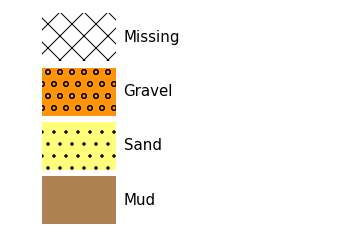

In [3]:
# and this is how Beds will look when plotted
litholog.defaults.litholegend.plot()

In [4]:
# modify the legend
litholog.defaults.sand_decor.colour = 'blue'

# and see if it worked
litholog.defaults.litholegend

Legend(Decor({'component': Component({'lithology': 'mud'}), '_colour': '#ad8150', 'hatch': None, 'width': -6.0})
Decor({'component': Component({'lithology': 'sand'}), '_colour': '#0000ff', 'hatch': '.', 'width': -1.0})
Decor({'component': Component({'lithology': 'gravel'}), '_colour': '#ff9408', 'hatch': 'o', 'width': 4.0})
Decor({'component': Component({'lithology': 'missing'}), '_colour': '#ffffff', 'hatch': 'x', 'width': -1.0}))

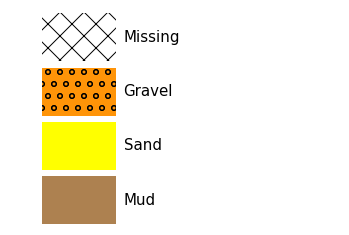

In [5]:
# modify things again
litholog.defaults.sand_decor.colour = 'yellow'
litholog.defaults.sand_decor.hatch = None

# call the plot function - note sand doesnt have dots any more
litholog.defaults.litholegend.plot()

## Make a `Bed` and a `BedSequence` from scratch

In [6]:
# Make a Bed

# make some fake data
top, base = 1, 2
data = {'lit1': 5, 'arr1': [1,2,3], 'arr2': [4,5,6]}

# assign to a Bed
B = litholog.Bed(top, base, data)
print(B.order) # litholog determines order based on whether the top is larger than the base (see more below)
B

depth


Interval({'data': {'lit1': 5, 'arr1': [1, 2, 3], 'arr2': [4, 5, 6]}, 'top': Position({'middle': 1.0, 'units': 'm'}), 'base': Position({'middle': 2.0, 'units': 'm'}), 'description': '', 'components': []})

If we want to make a more realistic example, here is one below. We need the `Component` from `striplog` to assign the `primary` lithology to each bed. We also use `data` and `metadata` from litholog to store other data, and could also add `metadata`

In [7]:
bed1 = Bed(top = 1, base = 0, data = {'grain_size_mm':0.125}, components = [Component({'lithology' : 'sand'})])
bed2 = Bed(top = 1.1, base = 1, data = {'grain_size_mm':0.02}, components = [Component({'lithology' : 'mud'})])
bed3 = Bed(top = 1.8, base = 1.1, data = {'grain_size_mm':50}, components = [Component({'lithology' : 'gravel'})])

bed_x = Bed(top=0, base=1, data={'lithology':'sand'})

print(bed2,'\n')

print(bed1.order)
print(bed_x.order,'\n')

print(bed1['lithology'])

{'data': {'grain_size_mm': 0.02}, 'top': Position({'middle': 1.1, 'units': 'm'}), 'base': Position({'middle': 1.0, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'mud'})]} 

elevation
depth 

None


In [8]:
seq1 = BedSequence([bed1, bed2, bed3],metadata={'name':'litholog test BedSequence'})

print(seq1.metadata)

# let's access the first bed in the sequence
seq1[0] # first bed is the uppermost because elevation-ordered

{'name': 'litholog test BedSequence'}


Interval({'data': {'grain_size_mm': 50}, 'top': Position({'middle': 1.8, 'units': 'm'}), 'base': Position({'middle': 1.1, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'gravel'})]})

In [9]:
#access the tops in the sequence using list comprehension
print('Bed tops:',[bed.top.upper for bed in seq1],'\n')

# To access the data fields, use "get_field"
print('grain size data:',seq1.get_field('grain_size_mm'),'\n')

# you can also look at the summary of a bed
print('uppermost bed summary:',seq1[0].summary(),'\n')

# or all the summaries
print('Summaries',[bed.summary() for bed in seq1],'\n')

Bed tops: [1.8, 1.1, 1.0] 

grain size data: [5.00e+01 2.00e-02 1.25e-01] 

uppermost bed summary: 0.70 m of gravel 

Summaries ['0.70 m of gravel', '0.10 m of mud', '1.00 m of sand'] 



## Plotting a `BedSequence`

### Simple plotting 

With no arguments, the aspect of the figure is default to 10 and the width of each bed (i.e., the grain size) is the default for the lithology given in `primary`, not the data in `grain_size_mm`. See below on how to further control this:


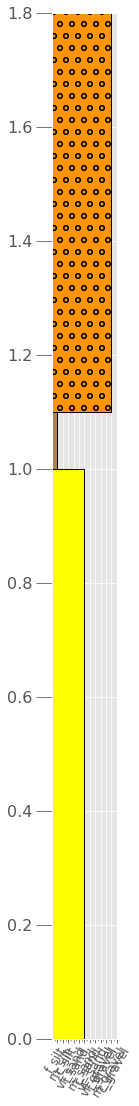

In [10]:
seq1.plot()

If we want to make a nicer plot that usess the exaact grain size, we need to make a log2 grain-size,  which is much easier to plot and visualize rather than using millimeters. We use the functions of `wentworth` to do this, and we will create PSI units instead of PHI units, because they increase with increasing grain size:

In [11]:
# make a grain_size_psi column
for bed in seq1:
    bed.data['grain_size_psi'] = litholog.wentworth.gs2psi(bed.data['grain_size_mm'])

seq1[-1] # see that it happened for the lowermost bed

Interval({'data': {'grain_size_mm': 0.125, 'grain_size_psi': -3.0}, 'top': Position({'middle': 1.0, 'units': 'm'}), 'base': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'sand'})]})

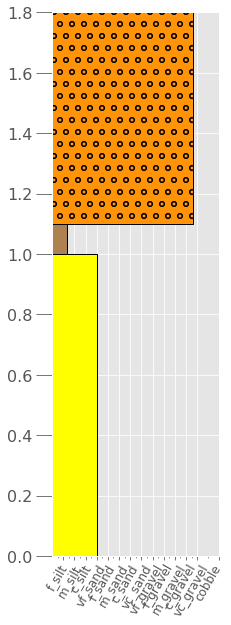

In [12]:
# Now we can make a nicer looking plot that uses the grain size data

# set up a figure
fig, ax = plt.subplots(figsize=[3,10])

# call the plot method, using the grain_size_psi as the width_field
seq1.plot(ax=ax,
          legend=litholog.defaults.litholegend,
          width_field='grain_size_psi',
          wentworth='fine'
         )
plt.show()
# The plot below might not look drastically different from the one above, but it is several PSI units different...

### Adding intra-`Bed` grain-size data to a plot

What if you want to display grain-size profiles within a bed? Not to worry, you just need to feed litholog that data:

In [13]:
# let's just change the lower sand bed to have a fining-up profile. I chose exact PSI units here, but you get the idea
bed1 = Bed(top = 1, base = 0, data = {'depth_m':[0, 0.05, 0.1, 0.9, 1],'grain_size_mm':[1, 0.5, 0.25, 0.125, 0.0884]}, components = [Component({'lithology' : 'sand'})])

# and the conlomgerate bed to have coarsening up
bed3 = Bed(top = 1.8, base = 1.1, data = {'depth_m':[1.1, 1.2, 1.5, 1.8],'grain_size_mm':[5, 20, 30, 80]}, components = [Component({'lithology' : 'gravel'})])

# and let's also add a missing (i.e., covered) interval at the top:
# NOTE - you can make whatever grain size you want for missing intervals... I choose 0.125 so it plots nicely
bed4 = Bed(top = 2.1, base = 1.8, data = {'grain_size_mm':0.125}, components = [Component({'lithology' : 'missing'})])

# make a new BedSequence
seq2 = BedSequence([bed1, bed2, bed3, bed4])

# create grain_size_psi 
for bed in seq2:
    bed.data['grain_size_psi'] = litholog.wentworth.gs2psi(bed.data['grain_size_mm'])

# and look at the covered 'bed'
seq2[1]

Interval({'data': {'depth_m': [1.1, 1.2, 1.5, 1.8], 'grain_size_mm': [5, 20, 30, 80], 'grain_size_psi': array([2.32192809, 4.32192809, 4.9068906 , 6.32192809])}, 'top': Position({'middle': 1.8, 'units': 'm'}), 'base': Position({'middle': 1.1, 'units': 'm'}), 'description': '', 'components': [Component({'lithology': 'gravel'})]})

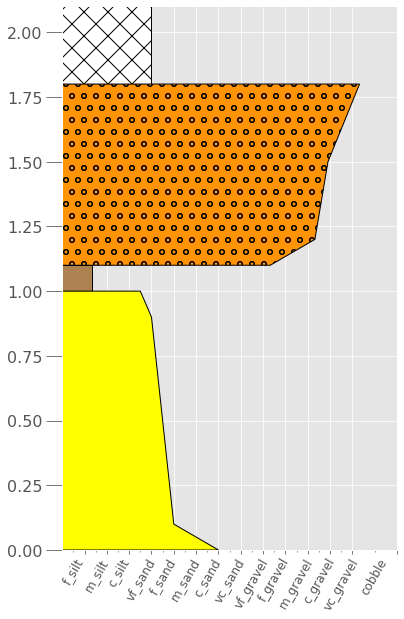

In [43]:
# Plot it just like before, but we need to add a depth field 
fig, ax = plt.subplots(figsize=[6,10])

seq2.plot(ax=ax,
          legend=litholog.defaults.litholegend,
          width_field='grain_size_psi',
          depth_field='depth_m',
          wentworth='fine',
         )

# and let's save it out
fig.savefig('fig2.eps',format='eps')

### Other plotting methods

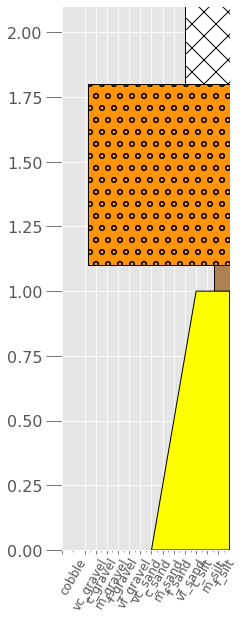

In [15]:
# And if you want to plot it Exxon-style, just add that argument
fig, ax = plt.subplots(figsize=[3,10])

seq2.plot(ax=ax,
          legend=litholog.defaults.litholegend,
          width_field='grain_size_psi',
          depth_field='depth_m',
          wentworth='fine',
          exxon_style=True
         );

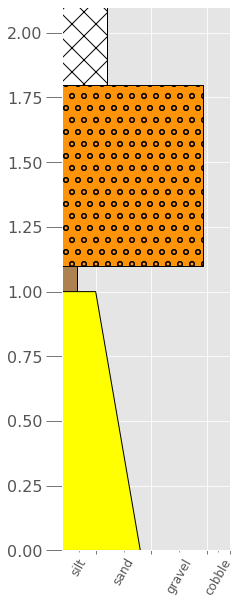

In [16]:
# Or if you want to make the x-axis simpler (can use fine, medium, or coarse):
fig, ax = plt.subplots(figsize=[3,10])

seq2.plot(ax=ax,
          legend=litholog.defaults.litholegend,
          width_field='grain_size_psi',
          depth_field='depth_m',
          wentworth='coarse',
          exxon_style=False
         );